 # Set Up the Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
data_dir = '/content/drive/My Drive/breast_cancer_dataset'
normal_dir = os.path.join(data_dir, 'NORMAL')
idc_dir = os.path.join(data_dir, 'IDC')

# Install Necessary Libraries


In [ ]:
!pip install tensorflow opencv-python

#Data Preprocessing
Write a data preprocessing pipeline to resize images, enhance contrast, and perform data augmentation.

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Parameters
img_height, img_width = 150, 150  # Resize dimensions
batch_size = 32

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation
)

# Load and preprocess images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (img_height, img_width))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(label)
    return images, labels

normal_images, normal_labels = load_images_from_folder(normal_dir, 0)
idc_images, idc_labels = load_images_from_folder(idc_dir, 1)

# Combine and split the dataset
images = np.array(normal_images + idc_images)
labels = np.array(normal_labels + idc_labels)
x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Create generators
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size, subset='training')
val_generator = datagen.flow(x_val, y_val, batch_size=batch_size, subset='validation')

# Model Architecture
Define a CNN with residual connections.

In [ ]:
def residual_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, (1, 1), padding='same')(x)  # Match the number of filters
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = ELU()(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = ELU()(x)
    return x


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ELU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.optimizers import RMSprop

# Define the model
input_img = Input(shape=(img_height, img_width, 3))

x = Conv2D(64, (3, 3), padding='same')(input_img)
x = ELU()(x)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 64)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 128)
x = MaxPooling2D((2, 2))(x)

x = residual_block(x, 256)
x = GlobalAveragePooling2D()(x)

output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_img, outputs=output)

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 150, 150, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 elu (ELU)                   (None, 150, 150, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 75, 75, 64)           0         ['elu[0][0]']                 
 D)                                                                                           

#Train the Model
Train the model with early stopping and learning rate reduction.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
150/150 [==============================] - 62s 341ms/step - loss: 0.3622 - accuracy: 0.8783 - val_loss: 0.4051 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 36s 238ms/step - loss: 0.2348 - accuracy: 0.9013 - val_loss: 0.7687 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 35s 234ms/step - loss: 0.2214 - accuracy: 0.9062 - val_loss: 1.2062 - val_accuracy: 0.4300 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 34s 228ms/step - loss: 0.2112 - accuracy: 0.9094 - val_loss: 1.4554 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 36s 242ms/step - loss: 0.2080 - accuracy: 0.9183 - val_loss: 1.3298 - val_accuracy: 0.4467 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 38s 251ms/step - loss: 0.1956 - accuracy: 0.9225 - val_loss: 1.2804 - val_accuracy: 0.5733 - lr: 0.0010
Epoch 7/100
150/150 [=========================

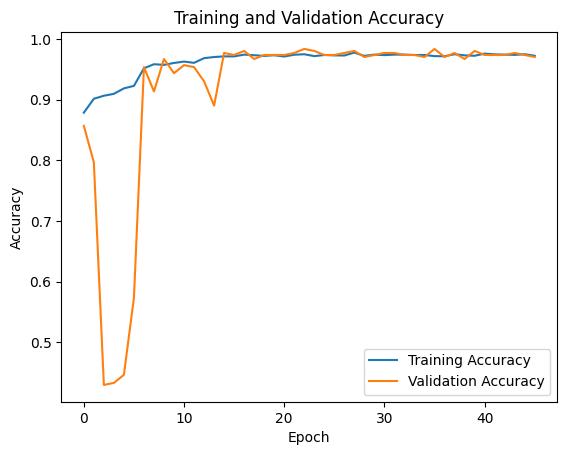

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


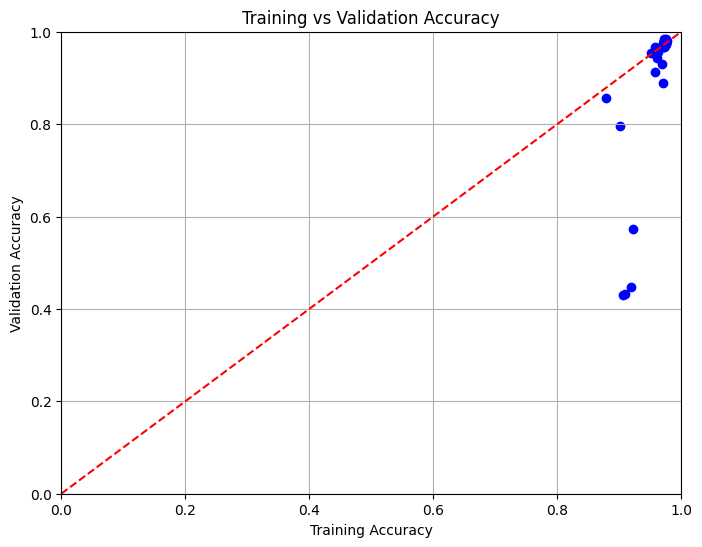

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracies
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(train_accuracies, val_accuracies, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line representing perfect agreement
plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


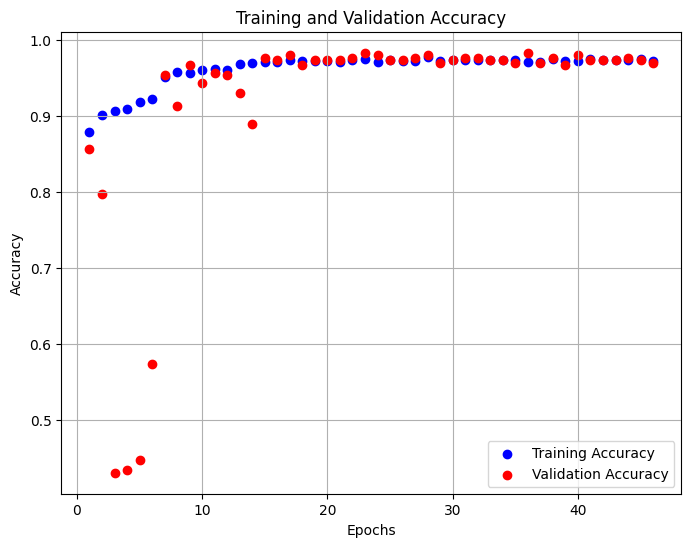

In [ ]:
import matplotlib.pyplot as plt

# Extract training and validation accuracies
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

# Create epochs range
epochs = range(1, len(train_accuracies) + 1)

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.scatter(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Define number of folds
k = 5

# Initialize lists to store evaluation metrics
train_accuracies = []
val_accuracies = []

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Perform k-fold cross-validation
for train_index, val_index in skf.split(images, labels):
    x_train_fold, x_val_fold = images[train_index], images[val_index]
    y_train_fold, y_val_fold = labels[train_index], labels[val_index]

    # Train your model on x_train_fold and y_train_fold
    # Here you need to compile and train your model, then evaluate it on x_val_fold and y_val_fold
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train_fold, y_train_fold, epochs=20, batch_size=32, verbose=0)
    _, train_accuracy = model.evaluate(x_train_fold, y_train_fold, verbose=0)
    _, val_accuracy = model.evaluate(x_val_fold, y_val_fold, verbose=0)

    # Append accuracies to the lists
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

# Calculate average accuracies
avg_train_accuracy = np.mean(train_accuracies)
avg_val_accuracy = np.mean(val_accuracies)

print("Average Training Accuracy:", avg_train_accuracy)
print("Average Validation Accuracy:", avg_val_accuracy)


Average Training Accuracy: 0.7985666751861572
Average Validation Accuracy: 0.7879999995231628


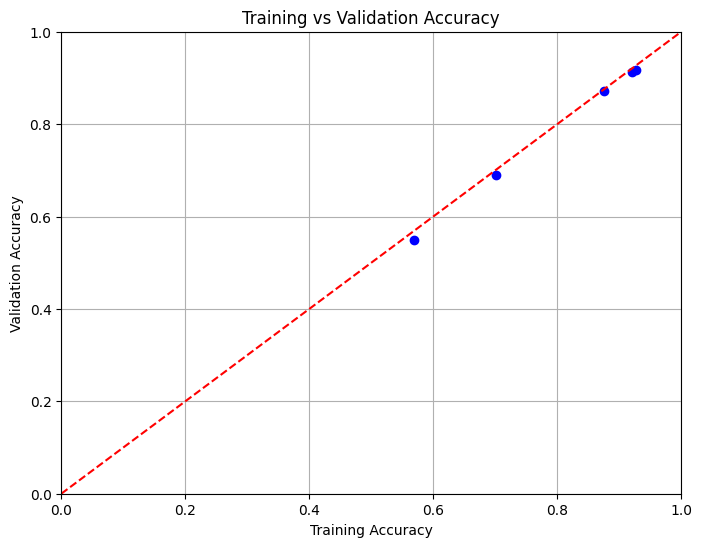

In [ ]:
import matplotlib.pyplot as plt

# Plot scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(train_accuracies, val_accuracies, color='blue')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line representing perfect agreement
plt.title('Training vs Validation Accuracy')
plt.xlabel('Training Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.show()


By comparing these training and validation accuracies across folds, you can assess the model's generalization performance and detect potential issues such as overfitting or underfitting. A good model should achieve similar accuracies on both the training and validation sets, indicating that it can generalize well to unseen data

#Evaluate the Model
Evaluate the model using accuracy, precision, recall, and ROC curve analysis.

In [ ]:
# Flatten the validation generator to get all validation images and labels
x_val_all = np.concatenate([x_val[i * batch_size:(i + 1) * batch_size] for i in range(len(x_val) // batch_size + 1) if len(x_val[i * batch_size:(i + 1) * batch_size]) > 0])
y_val_all = np.concatenate([y_val[i * batch_size:(i + 1) * batch_size] for i in range(len(y_val) // batch_size + 1) if len(y_val[i * batch_size:(i + 1) * batch_size]) > 0])

# Predict on the entire validation set
y_val_pred = model.predict(x_val_all)
y_val_pred_class = (y_val_pred > 0.5).astype(int)


47/47 [==============================] - 2s 47ms/step


# use another algorithms

In [ ]:
from sklearn.linear_model import LogisticRegression

# Create and train the model
logreg_model = LogisticRegression()
logreg_model.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Evaluate the model
logreg_accuracy = logreg_model.score(x_val.reshape(x_val.shape[0], -1), y_val)
print("Logistic Regression Accuracy:", logreg_accuracy)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.8613333333333333


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create and train the model
rf_model = RandomForestClassifier()
rf_model.fit(x_train.reshape(x_train.shape[0], -1), y_train)

# Evaluate the model
rf_accuracy = rf_model.score(x_val.reshape(x_val.shape[0], -1), y_val)
print("Random Forest Accuracy:", rf_accuracy)


Random Forest Accuracy: 0.896


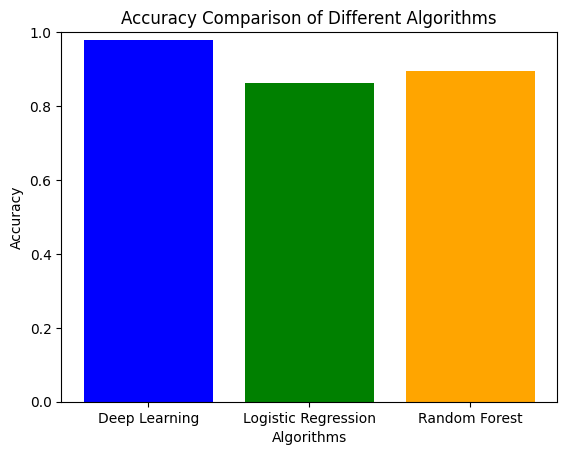

In [ ]:
import matplotlib.pyplot as plt

# Define algorithms and their accuracies
algorithms = ['Deep Learning', 'Logistic Regression', 'Random Forest']
accuracies = [history.history['val_accuracy'][-1], logreg_accuracy, rf_accuracy]

# Plot bar chart
plt.bar(algorithms, accuracies, color=['blue', 'green', 'orange'])
plt.title('Accuracy Comparison of Different Algorithms')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limit to 0-1
plt.show()
